# Generate vehicle routing problem instance

In [1]:
import qiskit
print(qiskit.version.get_version_info())

2.1.1


In [2]:
import numpy as np

n = 4  # number of nodes + depot (n+1)
K = 2  # number of vehicles

# Get the data randomly placed nodes
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):
        n = self.n

        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance
    
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [3]:
print(instance)

[[ 0.         36.84023052  5.061353   30.63150414]
 [36.84023052  0.         24.55322904 63.21893593]
 [ 5.061353   24.55322904  0.         15.49719877]
 [30.63150414 63.21893593 15.49719877  0.        ]]


# Functions to convert problem to QUBO


In [4]:
# from qiskit_optimization.problems.quadratic_program import QuadraticProgram
import networkx as nx
import itertools
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.problems import QuadraticProgram


def vehicle_routing_to_quadratic_program(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    """
    Convert a vehicle routing problem instance into a QuadraticProgram.

    Args:
        graph: A networkx graph with edge weights representing distances or costs.
        depot: The index of the depot node.
        num_vehicles: The number of vehicles available.

    Returns:
        A QuadraticProgram representing the vehicle routing problem.
    """
    mdl = Model(name="Vehicle routing")
    n = graph.number_of_nodes()
    x = {}

    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")

    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )

    # Each node (except depot) has one outgoing and one incoming edge
    for i in range(n):
        if i != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for j in range(n) if i != j) == 1)
    for j in range(n):
        if j != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for i in range(n) if i != j) == 1)

    # Depot constraints: exactly num_vehicles enter and leave
    mdl.add_constraint(
        mdl.sum(x[i, depot] for i in range(n) if i != depot) == num_vehicles
    )
    mdl.add_constraint(
        mdl.sum(x[depot, j] for j in range(n) if j != depot) == num_vehicles
    )

    # Sub-tour elimination (using clique constraints)
    node_list = [i for i in range(n) if i != depot]
    for i in range(2, len(node_list) + 1):
        for clique in itertools.combinations(node_list, i):
            mdl.add_constraint(
                mdl.sum(x[i, j] for i in clique for j in clique if i != j) <= len(clique) - 1
            )

    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp


def vehicle_routing_to_objective(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    mdl = Model(name="Vehicle routing obj")
    n = graph.number_of_nodes()
    x = {}
    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")
    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )
    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp

def vehicle_routing_to_constraints(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    mdl = Model(name="Vehicle routing constraints")
    n = graph.number_of_nodes()
    x = {}

    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")

    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            0 * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )

    # Each node (except depot) has one outgoing and one incoming edge
    for i in range(n):
        if i != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for j in range(n) if i != j) == 1)
    for j in range(n):
        if j != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for i in range(n) if i != j) == 1)

    # Depot constraints: exactly num_vehicles enter and leave
    mdl.add_constraint(
        mdl.sum(x[i, depot] for i in range(n) if i != depot) == num_vehicles
    )
    mdl.add_constraint(
        mdl.sum(x[depot, j] for j in range(n) if j != depot) == num_vehicles
    )

    # Sub-tour elimination (using clique constraints)
    node_list = [i for i in range(n) if i != depot]
    for i in range(2, len(node_list) + 1):
        for clique in itertools.combinations(node_list, i):
            mdl.add_constraint(
                mdl.sum(x[i, j] for i in clique for j in clique if i != j) <= len(clique) - 1
            )

    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp    

# Linear program

In [5]:
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes and edges from the distance matrix
num_nodes = instance.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Avoid duplicate edges
        if instance[i, j] > 0:  # skip zero or invalid distances
            G.add_edge(i, j, weight=instance[i, j])

vrp_obj = vehicle_routing_to_objective(G, depot=0, num_vehicles=K)
vrp_con = vehicle_routing_to_constraints(G, depot=0, num_vehicles=K)
# q3 = vrp3.to_quadratic_program()
print(vrp_obj.prettyprint())
print(vrp_con.prettyprint())

Problem name: Vehicle routing obj

Minimize
  36.840230524848785*x_0_1 + 5.061352996006702*x_0_2 + 30.631504139776087*x_0_3
  + 36.840230524848785*x_1_0 + 24.553229038971544*x_1_2
  + 63.21893592648173*x_1_3 + 5.061352996006702*x_2_0 + 24.553229038971544*x_2_1
  + 15.497198766817078*x_2_3 + 30.631504139776087*x_3_0
  + 63.21893592648173*x_3_1 + 15.497198766817078*x_3_2

Subject to
  No constraints

  Binary variables (12)
    x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2

Problem name: Vehicle routing constraints

Minimize
  0

Subject to
  Linear constraints (12)
    x_1_0 + x_1_2 + x_1_3 == 1  'c0'
    x_2_0 + x_2_1 + x_2_3 == 1  'c1'
    x_3_0 + x_3_1 + x_3_2 == 1  'c2'
    x_0_1 + x_2_1 + x_3_1 == 1  'c3'
    x_0_2 + x_1_2 + x_3_2 == 1  'c4'
    x_0_3 + x_1_3 + x_2_3 == 1  'c5'
    x_1_0 + x_2_0 + x_3_0 == 2  'c6'
    x_0_1 + x_0_2 + x_0_3 == 2  'c7'
    x_1_2 + x_2_1 <= 1  'c8'
    x_1_3 + x_3_1 <= 1  'c9'
    x_2_3 + x_3_2 <= 1  'c10'
    x_1_2 + x_1_3 +

## To QUBO

In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

# conv = QuadraticProgramToQubo()
conv = QuadraticProgramToQubo(penalty=np.sum(instance)*2)    # ..............PENALTY................ penalty=np.sum(instance)
qubo_obj = conv.convert(vrp_obj)
qubo_con = conv.convert(vrp_con)

print(qubo_obj.export_as_lp_string())
#print(conv.penalty)
print("\n ----------------------------------- \n")
print(qubo_con.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Vehicle routing obj

Minimize
 obj: 36.840230524849 x_0_1 + 5.061352996007 x_0_2 + 30.631504139776 x_0_3
      + 36.840230524849 x_1_0 + 24.553229038972 x_1_2 + 63.218935926482 x_1_3
      + 5.061352996007 x_2_0 + 24.553229038972 x_2_1 + 15.497198766817 x_2_3
      + 30.631504139776 x_3_0 + 63.218935926482 x_3_1 + 15.497198766817 x_3_2
Subject To

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_1 <= 1
 0 <= x_2_3 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_1 <= 1
 0 <= x_3_2 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2
End


 ----------------------------------- 

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Vehicle routing constraints

Minimize
 obj: - 4219.258833429645 x_0_1 - 4219.258833429645 x_0_2
      - 4219.258833429645 x_0_3 - 4219.258833429645 x_1_0

In [7]:
Q = qubo_obj.objective.quadratic.to_array()
Q_con = qubo_con.objective.quadratic.to_array()

# Simplify diagonal terms: x^2 = x
linear = qubo_obj.objective.linear.to_array()
linear_con = qubo_con.objective.linear.to_array()
diag = np.diag(Q)

# Update linear: x^2 term becomes x
simplified_linear = linear + diag
simplified_linear_con = linear_con + np.diag(Q_con)

# Zero out the diagonal in the quadratic matrix
np.fill_diagonal(Q, 0)

# Optional: print simplified objective
print("Simplified linear:", simplified_linear)
print("Simplified quadratic (off-diagonal):\n", Q)

Simplified linear: [36.84023052  5.061353   30.63150414 36.84023052 24.55322904 63.21893593
  5.061353   24.55322904 15.49719877 30.63150414 63.21893593 15.49719877]
Simplified quadratic (off-diagonal):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
def build_qubo_from_arrays(linear, quadratic, variable_names=None):
    n = len(linear)
    qp = QuadraticProgram()
    
    # If variable names are not given, create default names
    if variable_names is None:
        variable_names = [f'x{i}' for i in range(n)]
    
    # Add binary variables
    for name in variable_names:
        qp.binary_var(name._name)
    
    # Add objective: minimize linear + quadratic terms
    linear_dict = {variable_names[i]._name: linear[i] for i in range(n)}
    
    # Only use upper triangle of Q to avoid double-counting
    quadratic_dict = {}
    for i in range(n):
        for j in range(i + 1, n):
            # if quadratic[i, j] != 0:
            quadratic_dict[(variable_names[i]._name, variable_names[j]._name)] = quadratic[i, j]
   
    # Normalize coefficients    
    max_lin_coeff = max(abs(v) for v in linear_dict.values())
    max_quad_coeff = max(abs(v) for v in quadratic_dict.values())

    if max_lin_coeff > max_quad_coeff:
        linear_dict_normed = {k: v / max_lin_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_lin_coeff for k, v in quadratic_dict.items()}
    else:
        linear_dict_normed = {k: v / max_quad_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_quad_coeff for k, v in quadratic_dict.items()}       
    
    qp.minimize(linear=linear_dict_normed, quadratic=quadratic_dict_normed)
    
    return qp

In [9]:
qubo_simple_obj = build_qubo_from_arrays(simplified_linear, Q, variable_names=qubo_obj.variables)
print(qubo_simple_obj.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 0.582740439790 x_0_1 + 0.080060711586 x_0_2 + 0.484530523820 x_0_3
      + 0.582740439790 x_1_0 + 0.388384092189 x_1_2 + x_1_3
      + 0.080060711586 x_2_0 + 0.388384092189 x_2_1 + 0.245135394003 x_2_3
      + 0.484530523820 x_3_0 + x_3_1 + 0.245135394003 x_3_2
Subject To

Bounds
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_0_3 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_2 <= 1
 0 <= x_1_3 <= 1
 0 <= x_2_0 <= 1
 0 <= x_2_1 <= 1
 0 <= x_2_3 <= 1
 0 <= x_3_0 <= 1
 0 <= x_3_1 <= 1
 0 <= x_3_2 <= 1

Binaries
 x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2
End



In [10]:
qubo_simple_con = build_qubo_from_arrays(simplified_linear_con, Q_con, variable_names=qubo_con.variables)
print(qubo_simple_con.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 0.800000000000 x_0_1 - 0.800000000000 x_0_2 - 0.800000000000 x_0_3
      - 0.800000000000 x_1_0 - x_1_2 - x_1_3 - 0.800000000000 x_2_0 - x_2_1
      - x_2_3 - 0.800000000000 x_3_0 - x_3_1 - x_3_2
      - 0.600000000000 c11@int_slack@0 - 0.600000000000 c11@int_slack@1 + [
      0.800000000000 x_0_1*x_0_2 + 0.800000000000 x_0_1*x_0_3
      + 0.800000000000 x_0_1*x_2_1 + 0.800000000000 x_0_1*x_3_1
      + 0.800000000000 x_0_2*x_0_3 + 0.800000000000 x_0_2*x_1_2
      + 0.800000000000 x_0_2*x_3_2 + 0.800000000000 x_0_3*x_1_3
      + 0.800000000000 x_0_3*x_2_3 + 0.800000000000 x_1_0*x_1_2
      + 0.800000000000 x_1_0*x_1_3 + 0.800000000000 x_1_0*x_2_0
      + 0.800000000000 x_1_0*x_3_0 + 1.600000000000 x_1_2*x_1_3
      + 1.200000000000 x_1_2*x_2_1 + 0.800000000000 x_1_2*x_2_3
      + 0.800000000000 x_1_2*x_3_1 + 1.600000000000 x_1_2*x_3_2
      + 0.800000000000 x_1_2*c11@int_slack@0
      

In [11]:
num_variables = 0
for nam in qubo_con.variables:
    num_variables +=1
    print(nam._name)

x_0_1
x_0_2
x_0_3
x_1_0
x_1_2
x_1_3
x_2_0
x_2_1
x_2_3
x_3_0
x_3_1
x_3_2
c11@int_slack@0
c11@int_slack@1


In [12]:
def calculate_cost(candidate_bitstring, A, Q):
    if isinstance(candidate_bitstring, str):
        # Convert string to array of ints
        x = np.array([int(bit) for bit in candidate_bitstring])
    elif isinstance(candidate_bitstring, np.ndarray):
        x = candidate_bitstring
    elif isinstance(candidate_bitstring, list):
        # Handle list of strings or ints
        if all(isinstance(bit, str) for bit in candidate_bitstring):
            x = np.array([int(bit) for bit in candidate_bitstring])
        else:
            x = np.array(candidate_bitstring)
    else:
        raise TypeError("Unsupported bitstring type. Must be str, list, or np.ndarray.")

    return x @ Q @ x + A @ x

In [13]:
from qiskit.quantum_info import SparsePauliOp

In [14]:
ising_obj = qubo_simple_obj.to_ising()[0]

if num_variables > len(ising_obj.paulis[0]):
    d = num_variables - len(ising_obj.paulis[0])
    extended_op = ising_obj.tensor(SparsePauliOp.from_list([("I"*d, 1.0)]))
    ising_obj = extended_op

print(ising_obj)

SparsePauliOp(['IIIIIIIIIIIZII', 'IIIIIIIIIIZIII', 'IIIIIIIIIZIIII', 'IIIIIIIIZIIIII', 'IIIIIIIZIIIIII', 'IIIIIIZIIIIIII', 'IIIIIZIIIIIIII', 'IIIIZIIIIIIIII', 'IIIZIIIIIIIIII', 'IIZIIIIIIIIIII', 'IZIIIIIIIIIIII', 'ZIIIIIIIIIIIII'],
              coeffs=[-0.29137022+0.j, -0.04003036+0.j, -0.24226526+0.j, -0.29137022+0.j,
 -0.19419205+0.j, -0.5       +0.j, -0.04003036+0.j, -0.19419205+0.j,
 -0.1225677 +0.j, -0.24226526+0.j, -0.5       +0.j, -0.1225677 +0.j])


In [15]:
ising_con = qubo_simple_con.to_ising()[0]
print(ising_con)

SparsePauliOp(['IIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIIZII', 'IIIIIIIIIIZIII', 'IIIIIIIIIZIIII', 'IIIIIIIIZIIIII', 'IIIIIIIZIIIIII', 'IIIIIIZIIIIIII', 'IIIIIZIIIIIIII', 'IIIIZIIIIIIIII', 'IIIZIIIIIIIIII', 'IIZIIIIIIIIIII', 'IZIIIIIIIIIIII', 'ZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIIZIZ', 'IIIIIIZIIIIIIZ', 'IIIZIIIIIIIIIZ', 'IIIIIIIIIIIZZI', 'IIIIIIIIIZIIZI', 'IIZIIIIIIIIIZI', 'IIIIIIIIZIIZII', 'IIIIIZIIIIIZII', 'IIIIIIIIIZZIII', 'IIIIIIIIZIZIII', 'IIIIIIIZIIZIII', 'IIIIZIIIIIZIII', 'IIIIIIIIZZIIII', 'IIIIIIZIIZIIII', 'IIIIIZIIIZIIII', 'IIIZIIIIIZIIII', 'IIZIIIIIIZIIII', 'IZIIIIIIIZIIII', 'ZIIIIIIIIZIIII', 'IIIIIIZIZIIIII', 'IIIIIZIIZIIIII', 'IIIZIIIIZIIIII', 'IIZIIIIIZIIIII', 'IZIIIIIIZIIIII', 'ZIIIIIIIZIIIII', 'IIIIIIZZIIIIII', 'IIIIIZIZIIIIII', 'IIIIZIIZIIIIII', 'IIIIIZZIIIIIII', 'IIIZIIZIIIIIII', 'IIZIIIZIIIIIII', 'IZIIIIZIIIIIII', 'ZIIIIIZIIIIIII', 'IIIZIZIIIIIIII', 'IIZIIZIIIIIIII', 'IZIIIZIIIIIIII', 'ZIIIIZIIIIIIII', 'IIIZZIIIIIIIII', 'IIZIZIIIIIIIII', 'IIZZIIIIIIII

In [16]:
def xy_mixer_hamiltonian(n_qubits):
    """
    Generate an XY mixer Hamiltonian for QAOA as a SparsePauliOp.

    Args:
        n_qubits (int): Number of qubits.

    Returns:
        SparsePauliOp: The XY mixer Hamiltonian.
    """
    pauli_strings = []
    coeffs = []

    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            # XX term
            x_term = ['I'] * n_qubits
            x_term[i] = 'X'
            x_term[j] = 'X'
            pauli_strings.append(''.join(x_term))
            coeffs.append(0.5)

            # YY term
            y_term = ['I'] * n_qubits
            y_term[i] = 'Y'
            y_term[j] = 'Y'
            pauli_strings.append(''.join(y_term))
            coeffs.append(0.5)


    return SparsePauliOp(pauli_strings, coeffs)

In [17]:
def xy_ring_mixer_hamiltonian(n_qubits):
    """
    Generate an XY mixer Hamiltonian for QAOA as a SparsePauliOp.

    Args:
        n_qubits (int): Number of qubits.

    Returns:
        SparsePauliOp: The XY mixer Hamiltonian.
    """
    pauli_strings = []
    coeffs = []

    for i in range(n_qubits - 1):
        # XX term
        x_str = ['I'] * n_qubits
        x_str[i] = 'X'
        x_str[i + 1] = 'X'
        pauli_strings.append(''.join(x_str))
        coeffs.append(0.5)

        # YY term
        y_str = ['I'] * n_qubits
        y_str[i] = 'Y'
        y_str[i + 1] = 'Y'
        pauli_strings.append(''.join(y_str))
        coeffs.append(0.5)
    
    # Wrap-around term between first and last qubit
    # x_str = ['I'] * n_qubits
    # x_str[0] = 'X'
    # x_str[-1] = 'X'
    # pauli_strings.append(''.join(x_str))
    # coeffs.append(0.5)

    # y_str = ['I'] * n_qubits
    # y_str[0] = 'Y'
    # y_str[-1] = 'Y'
    # pauli_strings.append(''.join(y_str))
    # coeffs.append(0.5)
    
    return SparsePauliOp(pauli_strings, coeffs)

# Constraints QAOA

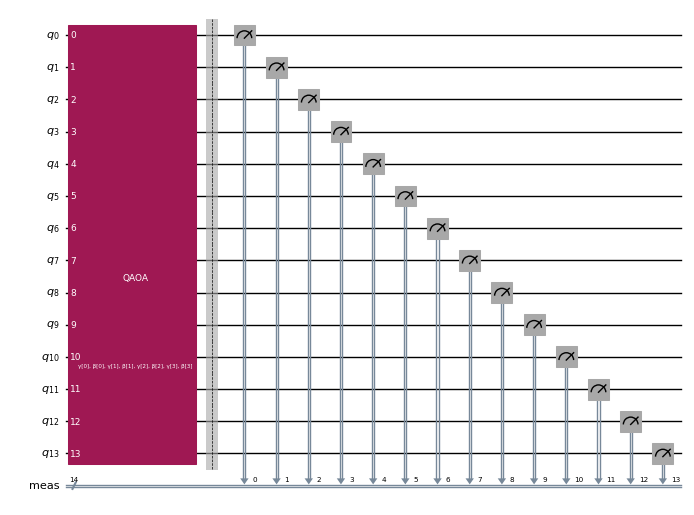

In [18]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=ising_con, reps=4)

circuit.measure_all()

circuit.draw('mpl', scale=0.5)

In [19]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3])])

In [20]:
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(circuit)
print(isa_circuit.count_ops())

OrderedDict([('rzz', 184), ('rz', 56), ('rx', 56), ('h', 14), ('measure', 14), ('barrier', 1)])


In [21]:
initial_gamma = np.pi
initial_beta = np.pi/2
# init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

init_params = [initial_gamma, initial_beta] * (len(circuit.parameters)//2)

# transform the observable defined on virtual qubits to observable defined on all physical qubits
isa_hamiltonian = ising_con.apply_layout(isa_circuit.layout)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    params_list.append(params)


    return cost

In [22]:
%%time
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from scipy.optimize import minimize


objective_func_vals = [] # Global variable
params_list = []

estimator = Estimator()

circuit.remove_final_measurements()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(isa_circuit, isa_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.3589843749999999
       x: [ 2.923e+00  1.554e+00  3.239e+00  1.753e+00  4.880e+00
            2.242e+00  3.229e+00  1.490e+00]
    nfev: 52
   maxcv: 0.0
CPU times: user 24min 4s, sys: 1.24 s, total: 24min 5s
Wall time: 50.1 s


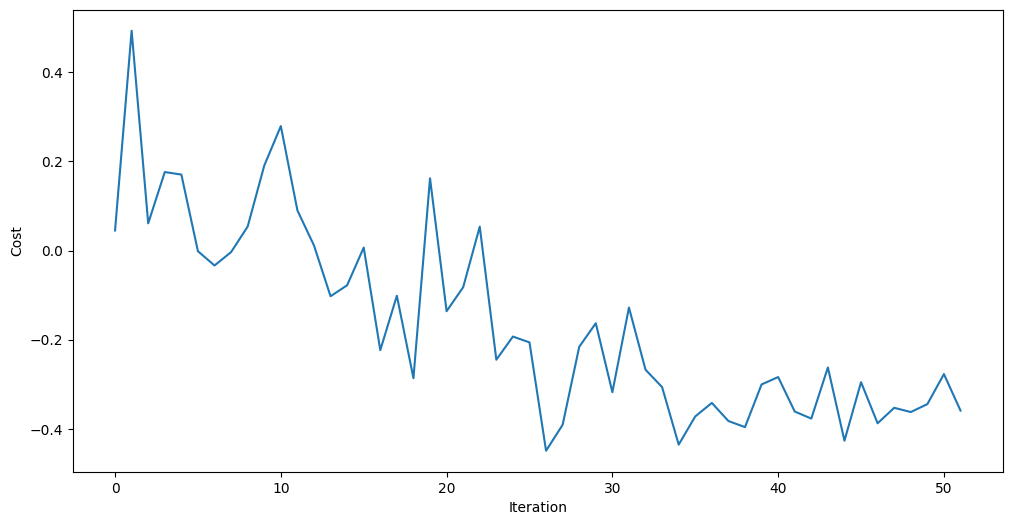

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()


In [24]:
print(result.x)

[2.92281897 1.5543331  3.23909739 1.75261338 4.87987724 2.24164902
 3.22946818 1.49035592]


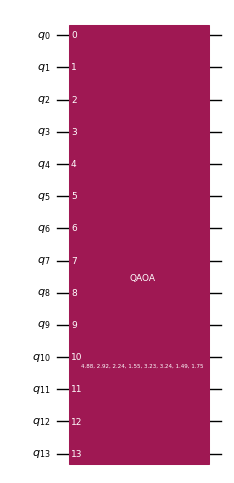

In [25]:
first_step = circuit.assign_parameters(result.x)
first_step.draw('mpl', scale=0.5)

In [26]:
first_step.parameters    # should have no tunable parameters now

ParameterView([])

# Cost QAOA

In [27]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=ising_obj, reps=4, initial_state=first_step, mixer_operator=xy_mixer_hamiltonian(num_variables))

In [29]:
isa_circuit = pass_manager.run(circuit) # using the Aer pass_manager
print(isa_circuit.count_ops())

OrderedDict([('rxx', 364), ('ryy', 364), ('rzz', 184), ('rz', 48), ('rx', 32), ('u3', 24), ('u2', 8), ('h', 6)])


In [30]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta] * (len(isa_circuit.parameters)//2)

# transform the observable defined on virtual qubits to observable defined on all physical qubits
isa_hamiltonian = ising_obj.apply_layout(circuit.layout)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    params_list.append(params)

    return cost

In [31]:
%%time
# from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
params_list = []

estimator = Estimator()

circuit.remove_final_measurements()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(isa_circuit, isa_hamiltonian, estimator),
    method="COBYQA",
    tol=1e-2,
)
print(result)

 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: -0.10138257423989618
       x: [ 2.941e+00  1.509e+00  3.218e+00  1.497e+00  2.234e+00
            2.202e+00  3.214e+00  2.152e+00]
     nit: 99
   maxcv: 0.0
    nfev: 146
CPU times: user 9.18 s, sys: 19.9 ms, total: 9.2 s
Wall time: 9.25 s


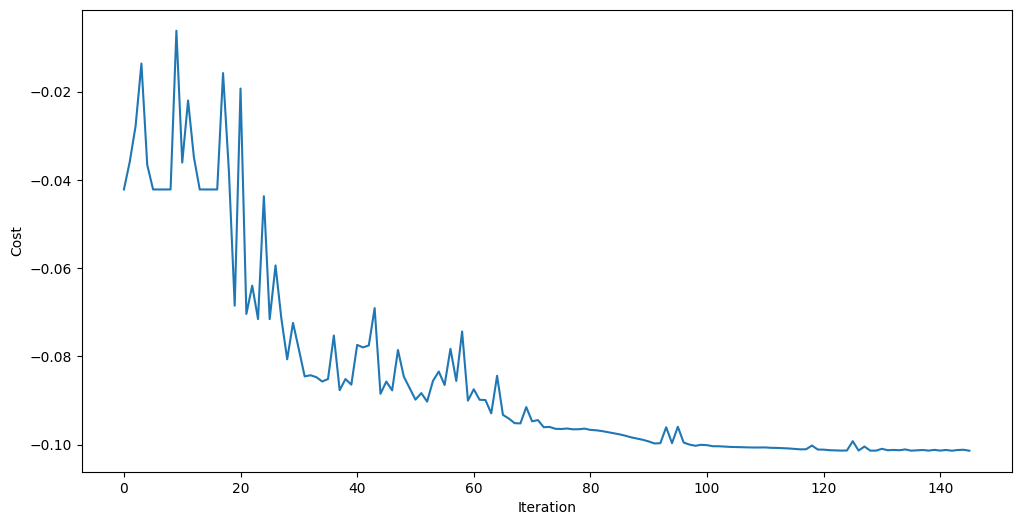

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [33]:
len(objective_func_vals)

146

In [34]:
optimized_circuit = isa_circuit.assign_parameters(result.x)
optimized_circuit.measure_all()

In [35]:
# from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_aer.primitives import SamplerV2 as Sampler

sampler = Sampler()

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [36]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_variables)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


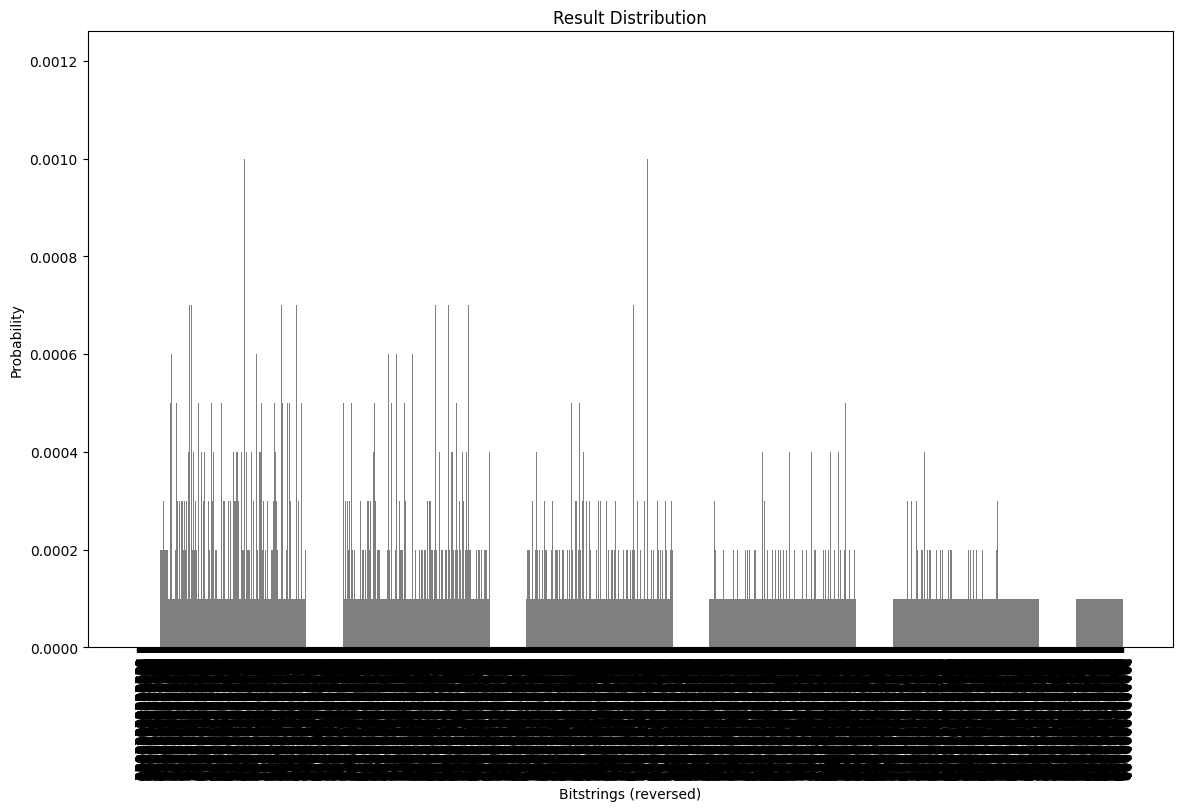

In [37]:
import matplotlib.pyplot as plt

final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
plt.show()

In [38]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    # plt.axis("equal")
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=9)

    plt.grid()

    for ii in range(0, len(x)):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n

            plt.quiver(
                xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], 
                angles="xy", scale_units="xy", scale=1, color="b", width=0.005, headwidth=7, headlength=7)
    
    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

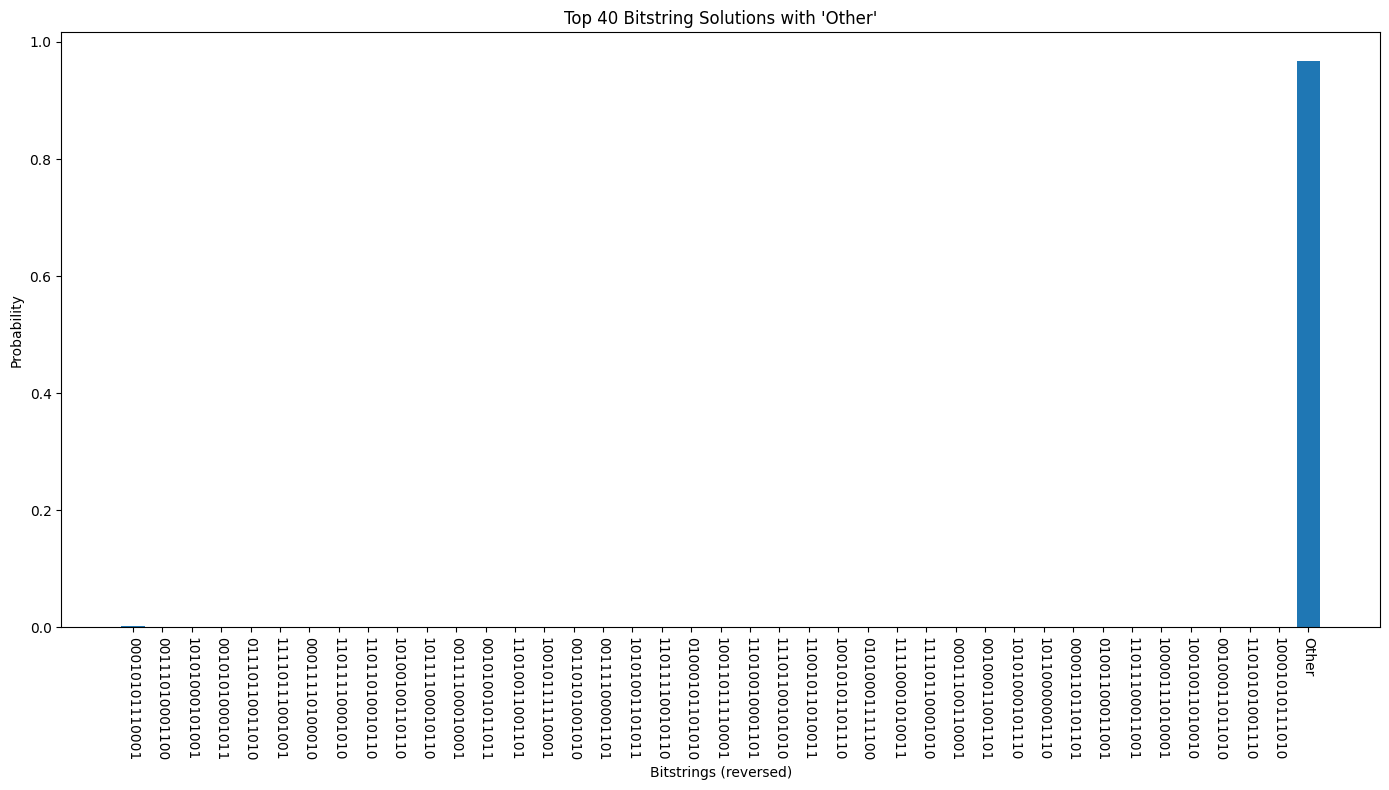

In [39]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and extract top r values
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]
other_sum = sum(val for _, val in sorted_items[r:])

# Prepare labels and values
labels = [k for k, _ in top_r] + ["Other"]
values = [v for _, v in top_r] + [other_sum]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Bitstring Solutions with 'Other'")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

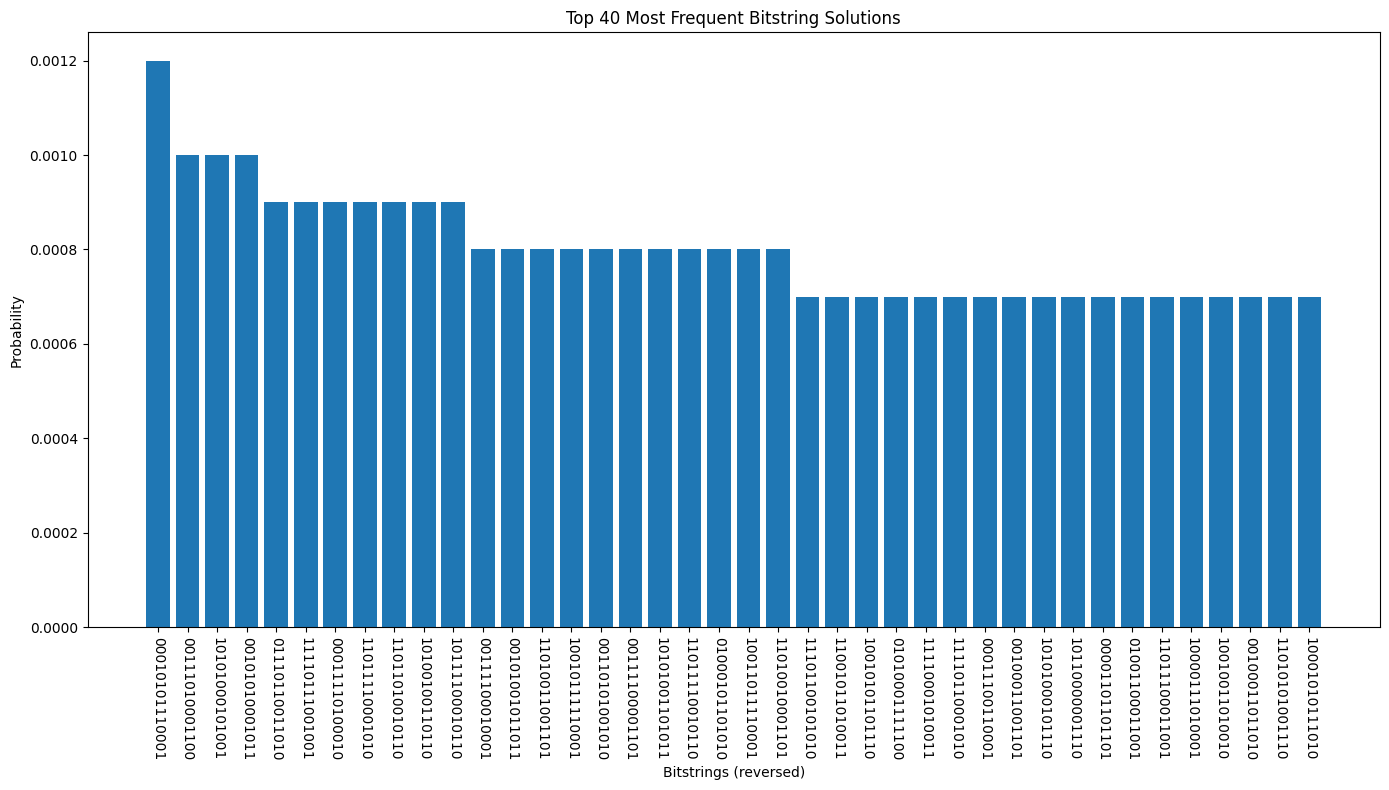

In [40]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and get top r
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]

# Extract bitstrings and probabilities
labels = [k for k, _ in top_r]
values = [v for _, v in top_r]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Most Frequent Bitstring Solutions")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

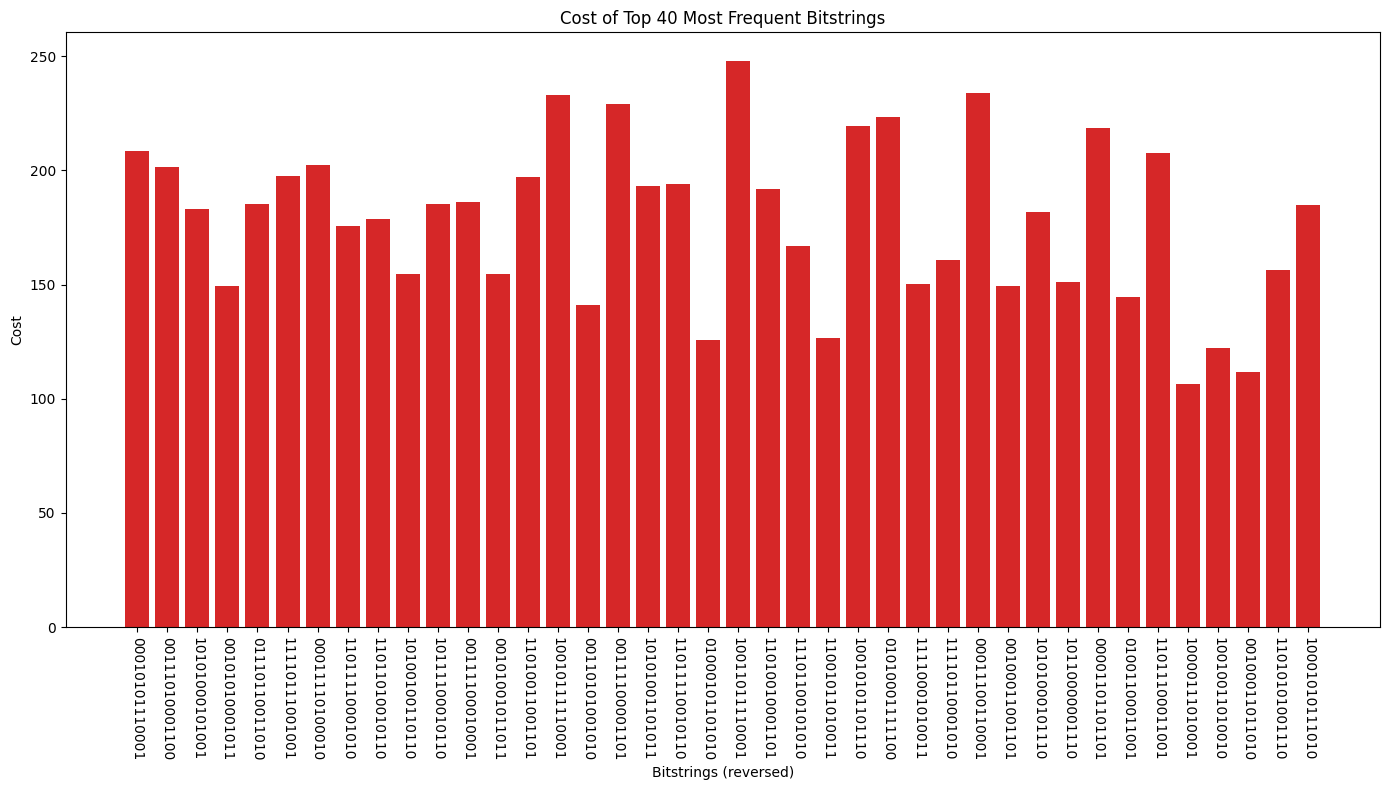

In [41]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Get top 20 bitstrings by probability
r=40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]
bitstrings = [k for k, _ in top_r]

# Compute cost for each top bitstring
costs = [calculate_cost(bs[-12:][::-1], simplified_linear, Q) for bs in bitstrings]

feasible_flags = []
for bs in bitstrings:
    x = np.array([int(b) for b in bs[-12:][::-1]])  # convert string to binary array
    feasible = vrp_con.is_feasible(x)
    feasible_flags.append(feasible)

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Cost of Top {r} Most Frequent Bitstrings")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Cost")

# Set bar colors based on feasibility
bar_colors = ["tab:blue" if f else "tab:red" for f in feasible_flags]
bars = ax.bar(bitstrings, costs, color=bar_colors)

# Optional: highlight top 4 lowest-cost solutions
lowest_cost_indices = np.argsort(costs)[:4]
# for i in lowest_cost_indices:
#     bars[i].set_color("tab:purple")

plt.tight_layout()
plt.show()

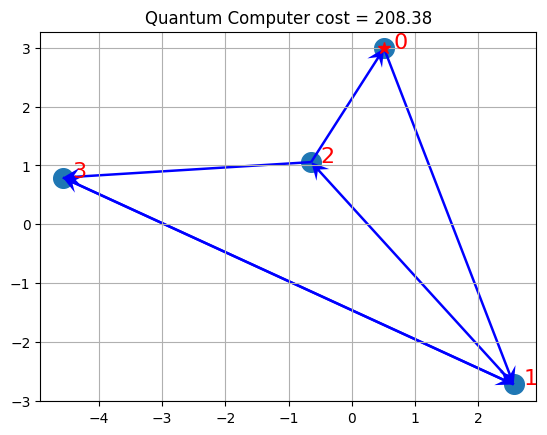

[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


In [42]:
# Put the solution in a way that is compatible with the classical variables
x_qc = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_qc[ii] = most_likely_bitstring[kk]
        kk += 1
  
qc_cost = calculate_cost(most_likely_bitstring[:12], simplified_linear, Q)
visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 
print(most_likely_bitstring)



[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]


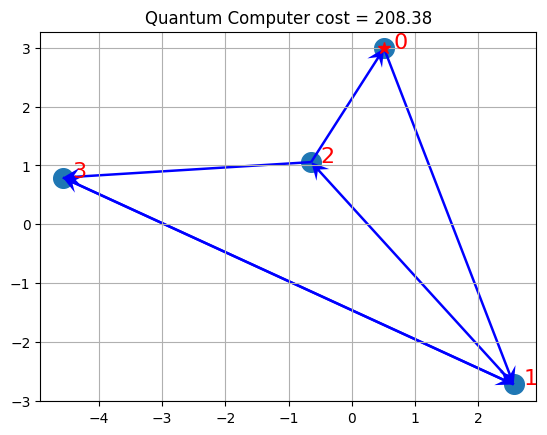



[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]


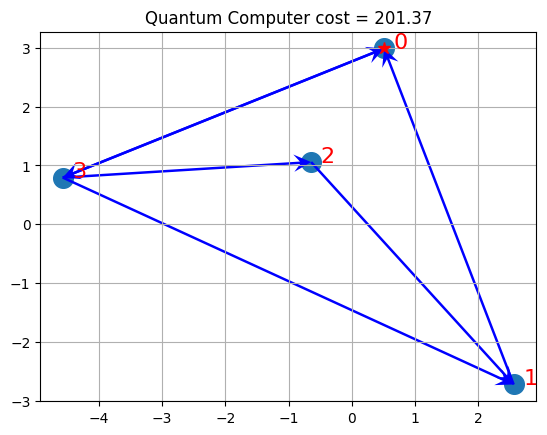



[1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]


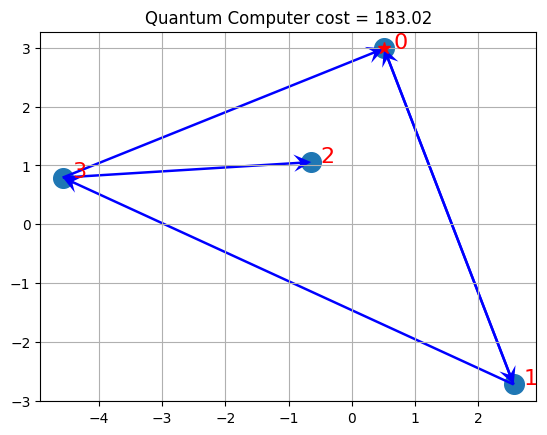



[1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]


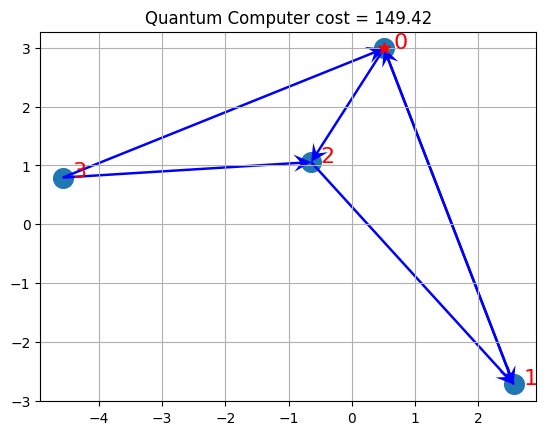



[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]


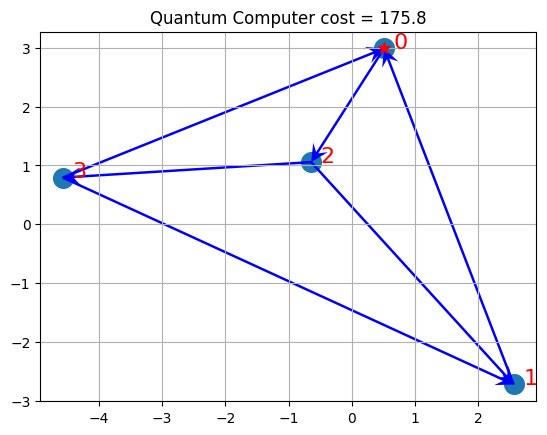



[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]


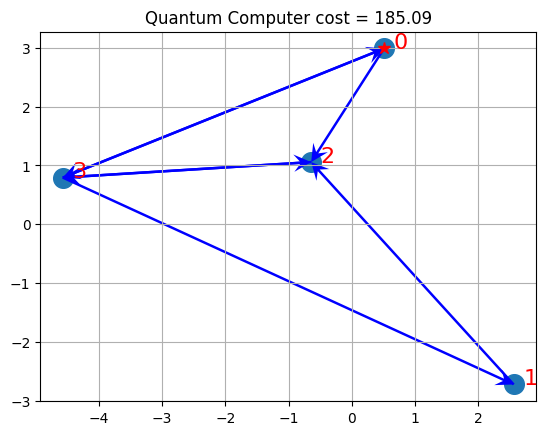



[0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1]


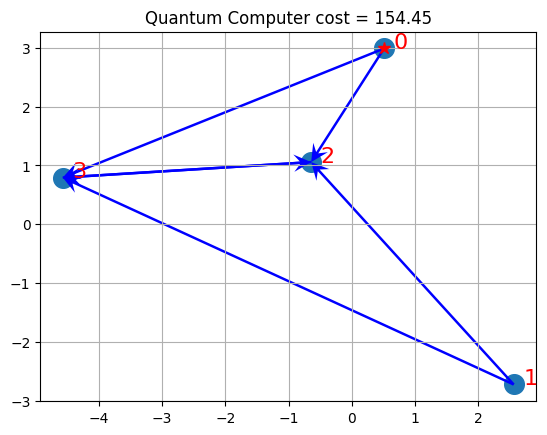



[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1]


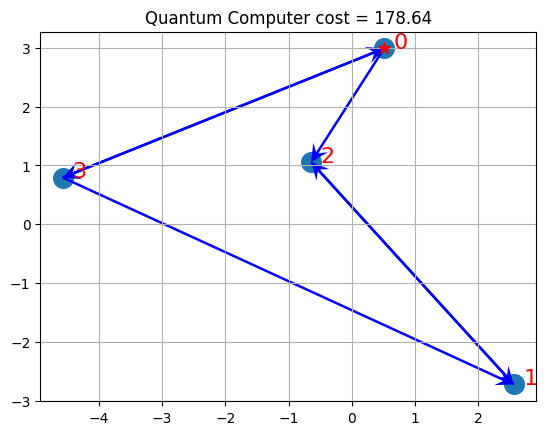



[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]


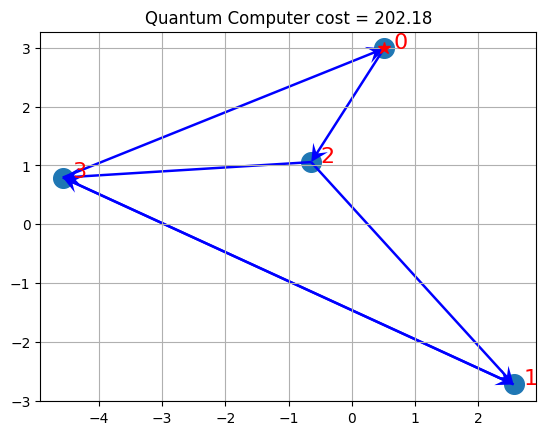



[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]


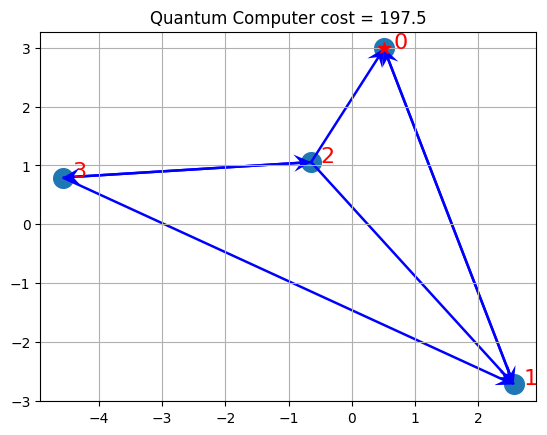



[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]


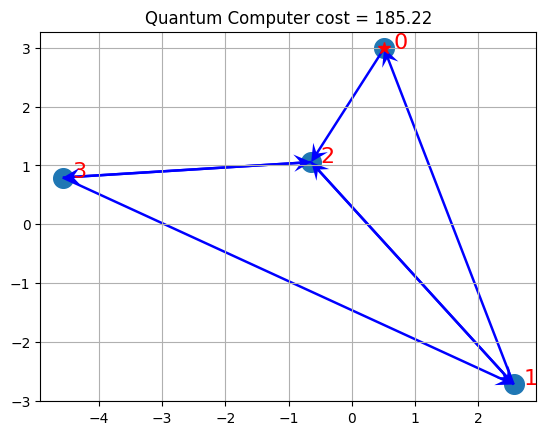



[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]


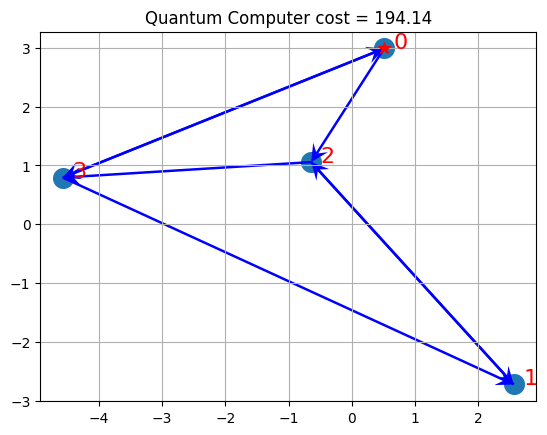



[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]


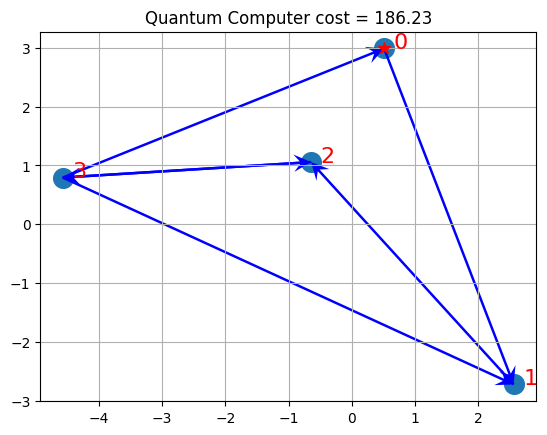



[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


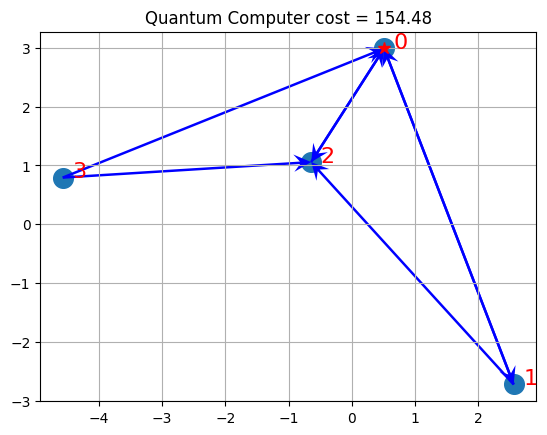



[1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


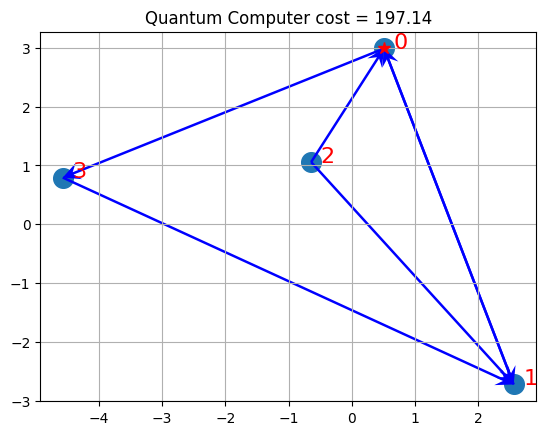



[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]


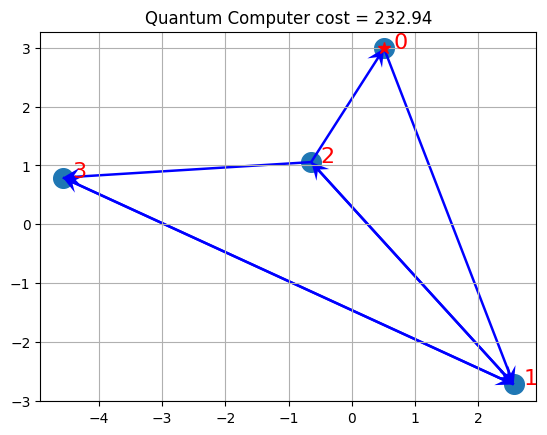



[0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]


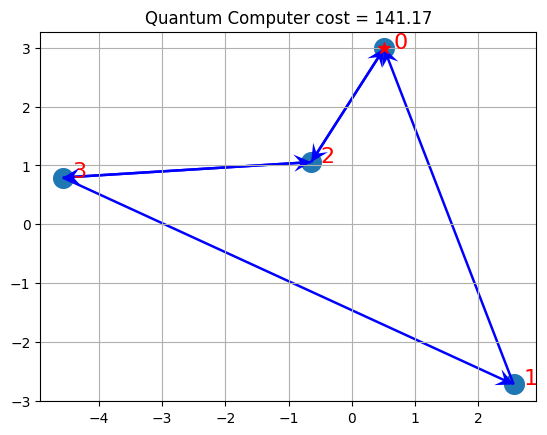



[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]


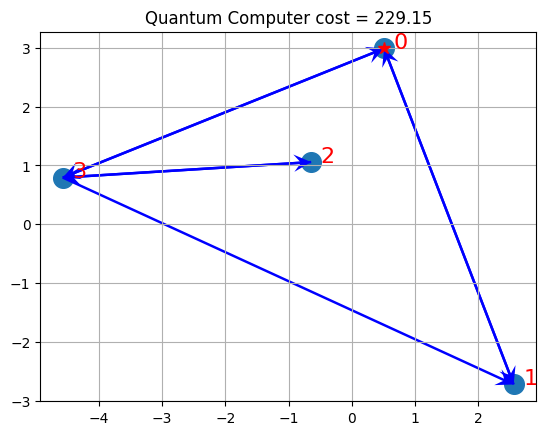



[1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]


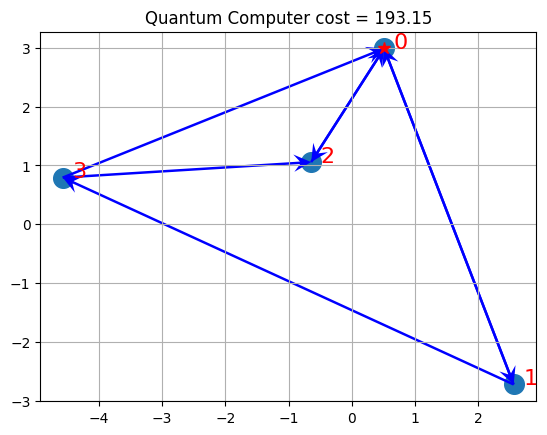



[0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]


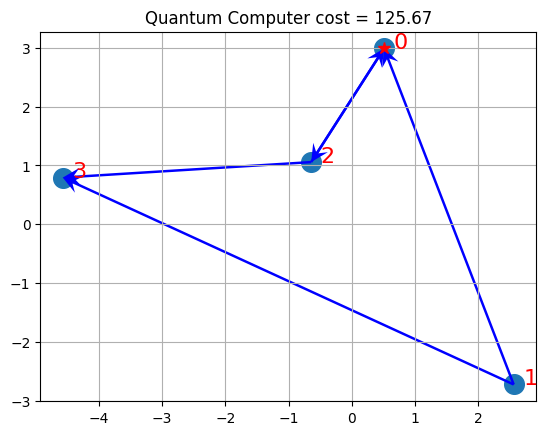

In [43]:
top_indices = np.argsort(np.abs(values))[-20:]
top_keys = [labels[t] for t in top_indices] 


for k in top_keys[::-1]:
    # m = to_bitstring(k, num_variables)
    m = [int(b) for b in k]
    m.reverse()
    print("\n")
    print(m)
    
    x_qc = np.zeros(n**2)
    kk = 0
    for ii in range(n**2):
        if ii // n != ii % n:
            x_qc[ii] = m[kk]
            kk += 1

    qc_cost = calculate_cost(m[:12], simplified_linear, Q)
    visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 

## Feasibility of top M bitstrings

In [48]:
M = 1000
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_M = sorted_items[:M]

bitstrings = [bs for bs, f in top_M]
freqs = [f for bs, f in top_M]

feasible_flags = []
feasible_freqs = []
idx=1
for bs, f in top_M:
    # convert string to binary array (last 12 bits, reversed)
    x = np.array([int(b) for b in bs[-12:][::-1]])
    feasible = vrp_con.is_feasible(x)
    feasible_flags.append(feasible)
    
    if feasible:
        feasible_freqs.append(f)
        print(vrp_obj.objective.evaluate(x), idx)
    idx +=1

# Count feasible bitstrings
feasible_count = sum(feasible_flags)
fraction_feasible = feasible_count / M

# Weighted fraction by frequencies
total_freq = sum(freqs)
feasible_freq_sum = sum(feasible_freqs)
fraction_feasible_weighted = feasible_freq_sum / total_freq

print(f"Feasible (count): {feasible_count}/{M}")
print(f"Fraction feasible (count): {fraction_feasible:.2%}")
print(f"Fraction feasible (weighted by frequency): {fraction_feasible_weighted:.2%}")

140.81337658312 583
140.81337658312 648
140.81337658312 815
124.87051695229744 976
Feasible (count): 4/1000
Fraction feasible (count): 0.40%
Fraction feasible (weighted by frequency): 0.29%
